In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
# read metadata
meta = pd.read_csv('Metadata\Surrey_Metadata_master_spreadsheet_130622_edit2.csv')

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
C:\Users\treharne\AppData\Local\Temp\ipykernel_2532\1503442191.py:2: SyntaxWarning: invalid escape sequence '\S'
  meta = pd.read_csv('Metadata\Surrey_Metadata_master_spreadsheet_130622_edit2.csv')


In [4]:
# Let's focus on the following columns
features = ["Age", "Airway Disease", "Covid Positive Hospital Swab (Y/N)", "Gender", "Lymphocytes", "Survived Admission", "Weight (kg)", "ICU admission ", "O2 req. " ]

# Set "Sample" as index
meta = meta.set_index("Sample")


# Let's create a new dataframe with only the features we are interested in
subset = meta[features]

# remove rows with missing values
subset = subset.dropna()

# remove rows with Age > 100
subset = subset[subset["Age"] <= 100]

check = subset.copy()

KeyError: "None of ['Sample'] are in the columns"

In [5]:
# Function to convert a value to binary
def convert_value_to_binary(x):
    # Convert the input to a lowercase string
    x = str(x).lower()
    
    # Check if the value is 'female' or 'f'
    if x == "female" or x == "f":
        return 1
    # Check if the value is 'male' or 'm'
    elif x == "male" or x == "m":
        return 0
    # Check if the value is neither 'n' nor '0'
    elif x != 'n' and x != '0' and x != 'no':
        return 1
    # Default case for any other value
    else:
        return 0

In [6]:
# Convert values in column 'Airway Disease' to binary using convert_value_to_binary function
subset['Airway Disease'] = subset['Airway Disease'].apply(convert_value_to_binary)
subset['Gender'] = subset['Gender'].apply(convert_value_to_binary)
subset['Survived Admission'] = subset['Survived Admission'].apply(convert_value_to_binary)
subset['ICU admission '] = subset['ICU admission '].apply(convert_value_to_binary)
subset['O2 req. '] = subset['O2 req. '].apply(convert_value_to_binary)
subset['Covid Positive Hospital Swab (Y/N)'] = subset['Covid Positive Hospital Swab (Y/N)'].apply(convert_value_to_binary)



In [7]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns you want to normalize
value_columns = ['Age', 'Weight (kg)']  # Replace with your actual column names

# Apply the scaler to the selected columns
subset[value_columns] = scaler.fit_transform(subset[value_columns])

In [8]:
subset.to_csv("normalised_metadata_key_features.csv", index=True)

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Separate the features and the target variable
X = subset.drop(columns=["O2 req. "])
y = subset['O2 req. ']

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

Training Accuracy: 0.9388888888888889
Test Accuracy: 0.7391304347826086
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.79      0.71        19
           1       0.83      0.70      0.76        27

    accuracy                           0.74        46
   macro avg       0.74      0.75      0.74        46
weighted avg       0.75      0.74      0.74        46

Best hyperparameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}


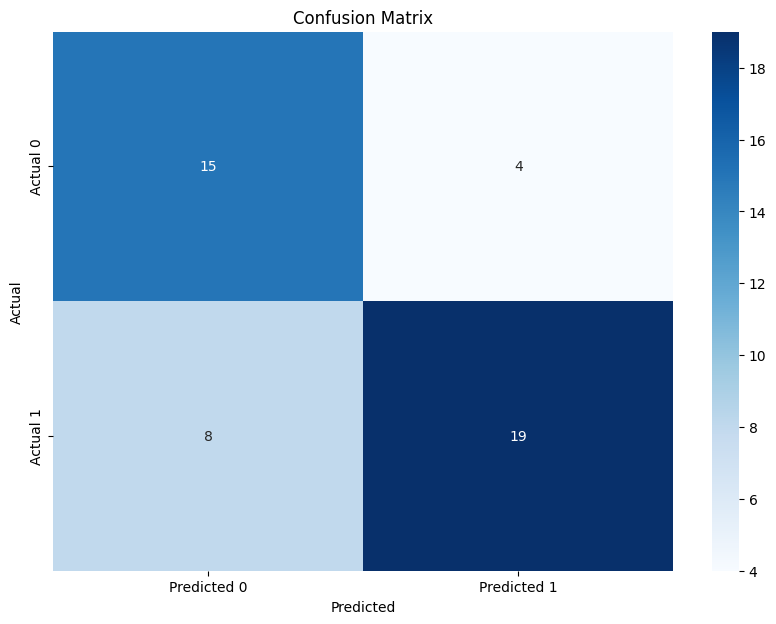

In [12]:
import numpy as np
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# Define the model with initial hyperparameters
model = RandomForestClassifier(random_state=42)

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [5],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = best_model.predict(X_train)

# Evaluate the model on training data
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy: {training_accuracy}')

# Make predictions on test data
y_test_pred = best_model.predict(X_test)

# Evaluate the model on test data
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_test_pred))
# Print the best hyperparameters
print("Best hyperparameters found: ", grid_search.best_params_)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

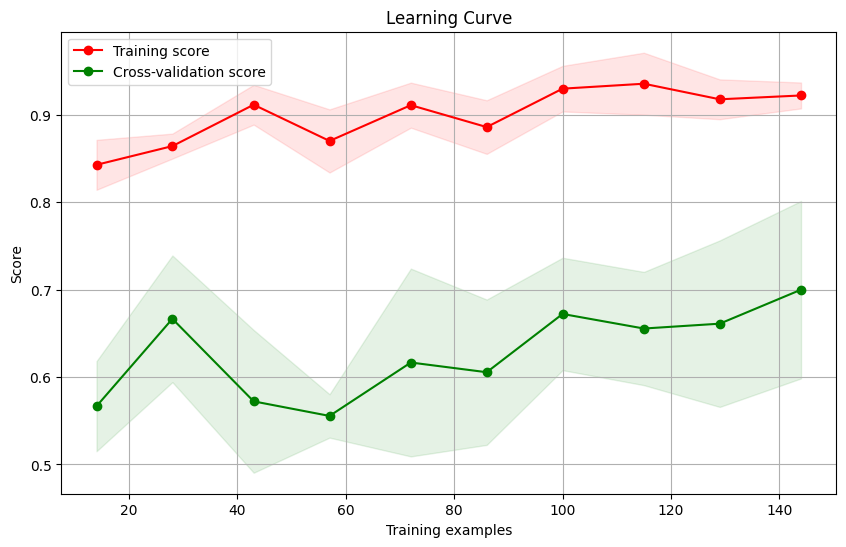

In [13]:
# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()

### Accuracy
- **Training Accuracy: 0.9833**: This indicates that the model correctly classified 98.33% of the training data.
- **Test Accuracy: 0.7391**: This indicates that the model correctly classified 73.91% of the test data.

### Classification Report
The classification report provides detailed metrics for each class (0 and 1).

#### Class 0
- **Precision: 0.68**: Out of all the instances predicted as class 0, 68% were actually class 0.
- **Recall: 0.68**: Out of all the actual instances of class 0, 68% were correctly predicted by the model.
- **F1-score: 0.68**: This is the harmonic mean of precision and recall, providing a balance between the two.

#### Class 1
- **Precision: 0.78**: Out of all the instances predicted as class 1, 78% were actually class 1.
- **Recall: 0.78**: Out of all the actual instances of class 1, 78% were correctly predicted by the model.
- **F1-score: 0.78**: This is the harmonic mean of precision and recall, providing a balance between the two.

### Overall Metrics
- **Accuracy: 0.74**: The overall accuracy of the model on the test data is 74%.
- **Macro avg**: This is the average of the precision, recall, and f1-score for both classes, treating all classes equally.
  - **Precision: 0.73**
  - **Recall: 0.73**
  - **F1-score: 0.73**
- **Weighted avg**: This is the average of the precision, recall, and f1-score for both classes, weighted by the number of instances in each class.
  - **Precision: 0.74**
  - **Recall: 0.74**
  - **F1-score: 0.74**

### Interpretation
- The model performs very well on the training data but significantly worse on the test data, indicating potential overfitting.
- The precision, recall, and f1-score for class 1 are higher than for class 0, suggesting the model performs better at predicting class 1.
- The overall test accuracy of 73.91% indicates that the model has moderate performance on unseen data, but there is room for improvement, especially in reducing overfitting.